### First we will read in data as images.

Train Population Size: 600
Test Population Size: 100


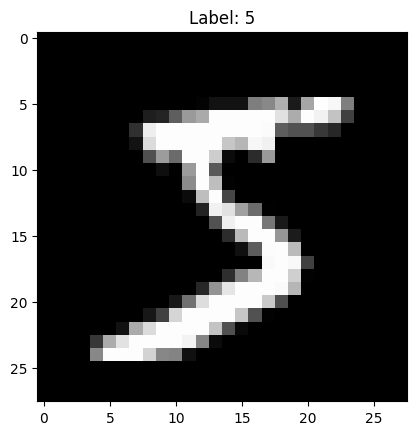

<class 'numpy.ndarray'>
(1, 28, 28)
Class: 0


In [2]:
# The following line was necessary to import the MNIST images.
# Source: https://stackoverflow.com/questions/78668638/unable-to-load-mnist-data-set-due-to-ssl-error-in-keras-load-data-function
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

# Libraries to include data and reading it in as images and arrays
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# Load MNIST dataset as images
train_dataset_as_images = dsets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset_as_images = dsets.MNIST(root='./data', train=False, download=True, transform=None)

# Load the MNIST dataset as arrays
train_dataset_as_arrays = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset_as_arrays = [(t.numpy(), c) for t,c in train_dataset_as_arrays]
test_dataset_as_arrays = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_dataset_as_arrays = [(t.numpy(), c) for t,c in test_dataset_as_arrays]

# The population is way too big for this notebook to handle in a reasonable amount of time - we'll scale down
train_indices = range(len(train_dataset_as_arrays))
train_sample_indices = random.sample(population=train_indices, k=int(0.01*len(train_indices)))
test_indicies = range(len(test_dataset_as_arrays))
test_sample_indices = random.sample(population=test_indicies, k=int(0.01*len(test_indicies)))
train_dataset_as_arrays = [train_dataset_as_arrays[i] for i in train_sample_indices]
test_dataset_as_arrays = [test_dataset_as_arrays[i] for i in test_sample_indices]
print(f"Train Population Size: {len(train_dataset_as_arrays)}")
print(f"Test Population Size: {len(test_dataset_as_arrays)}")

# Display the first sample image
first_image, first_label = train_dataset_as_images[0]
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {first_label}")
plt.show()

# Display said image as an array
first_image_array, first_label = train_dataset_as_arrays[0]
print(type(first_image_array))
print(first_image_array.shape)
print(f"Class: {first_label}")

### We need to create a neural network - at heart a list of matrices. We will then use perceptrons - each perceptron will know to reference a certain row of a certain matrix - for book keeping when updating the weights of the network.

In [ ]:
from math import exp
import numpy as np

class ANN:
    
    def __init__(self, input_dim: int, layer_dims: list[int], initialization_constant: int=1, lr: float=0.01):
        """Create an artificial neural network which is defined by the number of layers and the number of neurons per layer

        Args:
            layer_dims (list[int]): number of neurons per each respective layer
            num_classifications (int): number of different classes each input could belong to (i.e. for handwritten digits, this will be 10 --> representing 0-9)
            initialization_constant (int, optional): upper bound for maximum value of randomly initialized weights. Defaults to 1.
            lr (float, optional): scalar used when performing gradient descent. Defaults to 0.01.
        """
        weight_matrices = [-initialization_constant + 2*initialization_constant*np.random.randn(input_dim, layer_dims[0])] + [-initialization_constant + 2*initialization_constant*np.random.randn(prev_dim, next_dim) for prev_dim, next_dim in zip(layer_dims, layer_dims[1:])]
        linear_output_vectors = [np.zeros([1, n]) for n in layer_dims]
        activation_output_vectors = [np.zeros([1,n]) for n in layer_dims]
        self.__network_elements = None
        self.__merge_network_elements(weights=weight_matrices, linear_outputs=linear_output_vectors, activation_outputs=activation_output_vectors)
        
        self.__derivatives = [np.zeros([prev_dim, next_dim]) for prev_dim, next_dim in zip(layer_dims, layer_dims[1:])]
        # dL/dW_0, dL/dz_0, dL/da_0, dL/dW_1, dL/dz_1, dL/da_1, ..., etc.
        self.__learning_rate = lr
    
    def __merge_network_elements(self, weights: list[np.ndarray], linear_outputs: list[np.ndarray], activation_outputs: list[np.ndarray]):
        """Helper method to merge the network elements - including weight matrices, linear output vectors, and activation output vectors into one list

        Args:
            weights (list[np.ndarray]): weight matrices
            linear_outputs (list[np.ndarray]): linear output vectors
            activation_outputs (list[np.ndarray]): activation output vectors
        """
        # Merge into a list of [W0, z0, a0, W1, z1, a1, W2, z2, a2, etc...]
        i = 0
        network_components = [weights, linear_outputs, activation_outputs]
        self.__weight_matrices = []
        self.__linear_output_vectors = []
        self.__activation_output_vectors = []
        while any(network_components):
            if network_components[i]:
                next = network_components[i].pop(0)
                if i == 0:
                    self.__weight_matrices.append(next)
                elif i == 1:
                    self.__linear_output_vectors.append(next)
                else:
                    self.__activation_output_vectors.append(next)
                self.__network_elements.append(next)
            i = (i + 1) % 3
    
    def __sigmoid(x):
        return 1 / (1 + exp(-x))

    __vector_sigmoid_func = np.frompyfunc(__sigmoid, 1, 1)
    
    def __sigmoid(vector: np.ndarray) -> np.ndarray:
        """Helper function to apply the sigmoid activation function to a numpy array

        Args:
            vector (np.ndarray): vector to apply sigmoid on (element-wise)

        Returns:
            np.ndarray: resulting vector from sigmoid function
        """
        return ANN.__vector_sigmoid_func(vector)

    def __calculate_gradients(self, last_input: np.ndarray, last_output: np.ndarray, target_output: np.ndarray):
        """Given the numerical loss received from a training observation, calculate the gradient of the loss and update each weight accordingly

        Args:
            last_output (np.ndarray): predicted output for the last input vector
            target_output (np.ndarray): expected output for the last input vector (something like [0, 0, 0, 0, 1, 1, 1])
        """
        # We know the immediate gradient for the last layer
        self.__derivatives[-1] = 2 * (last_output - target_output) # vector
        for i in range(len(self.__derivatives)-1, 0, -1):
            if i % 3 == 0:
                # weight matrix derivative
                activation_output_layer = self.__network_elements[i-1] if i > 0 else last_input
                # dL/dW_i_k_j = dL/dz_i_k * dz_i_k/dW_i_k_j = dL/dz_i_k * a_{i-1}_j
                # dL/dW_i_k = dL/dz_i_k(a_{i-1})
                # dL/dW_i = (dL/dz_i) X (a_{i-1})
                dz_i_transpose = self.__derivatives[i+1].T
                self.__derivatives[i] = np.matmul(dz_i_transpose, activation_output_layer)
            elif i % 3 == 1:
                # linear output layer derivative
                activation_output_layer = self.__activation_output_vectors[i // 2]
                # dL/dz_i = dL/da_i * da_i/dz_i = dL/da_i * a_i * (1-a_i) since the derivative of sigmoid at x is sigmoid(x)(1-sigmoid(x))
                self.__derivatives[i] = self.__derivatives[i+1] * activation_output_layer * (np.ones(shape=activation_output_layer.shape) - activation_output_layer)
            else:
                # activation layer derivative
                pass 
            
    def __perform_batch_descent(self, batch: list[np.ndarray], batch_outputs: list[np.ndarray]):
        """Given a batch of observations, calculate the average gradient and update all weights accordingly

        Args:
            batch (list[np.ndarray]): list of input vectors
        """
        pass